# Numerical experiment 2

In [ ]:
import os
import numpy as np
import matplotlib.pylab as plt
from matplotlib import gridspec
os.chdir('../')
from src.dynamical_system.model import lorenz
from src.dynamical_system.simulate import simulate_rk4
from timeseries_modeling import Three_Layer_Feedforward_NN_using_ELM as TFNN_ELM

In [2]:
rcParams_dict = {
    'font.family':'Times New Roman',
    'mathtext.fontset':'stix',
    'font.size':15,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'axes.linewidth':1.5,
    'xtick.major.size':8,
    'ytick.major.size':8,}
for key in rcParams_dict.keys():plt.rcParams[str(key)] = rcParams_dict[str(key)]

In [99]:
### DEFINE
SEED = 0
SIGMA, RHO, BETA = 10., 28., 8/3
X_INIT, Y_INIT, Z_INIT = 17.6, 12.9, 43.9
SIMULATION_SETTINGS={'start time':0.,
                     'ending time':300.,
                     'time step size':0.01,}
N_UNIT_AFTER = 10000
N_TRAIN = 5000
N_TEST = 5000
HIDDEN_SIZE = 20
INPUT_W_SCALE = 0.1
ACTIVE_FUNC = "sigmoid"

In [13]:
### Simulate lorenz96
X, T = simulate_rk4(lorenz, (X_INIT, Y_INIT, Z_INIT), (SIGMA, RHO, BETA), SIMULATION_SETTINGS)
X = X[N_UNIT_AFTER:]
T = T[N_UNIT_AFTER:]
T -= T[0]
### Split X into train & test sets
x_train, x_test = X[:N_TRAIN], X[N_TRAIN:N_TRAIN+N_TEST]
T_train, T_test = T[:N_TRAIN], T[N_TRAIN:N_TRAIN+N_TEST]
del X, T

In [110]:
def rmse(X, X_hat):
    return np.sqrt(np.sum((X - X_hat)**2, axis=1) / X.shape[1])

def timeseries_modeling(x, x_hat, T, n_plt, sort=True):
    x_rmse = rmse(x[:n_plt], x_hat[:n_plt])
    if sort:
        x = x[:, np.argsort(np.var(x, axis=0))[::-1]]
        x_hat = x_hat[:, np.argsort(np.var(x, axis=0))[::-1]]

    spec = gridspec.GridSpec(ncols=1, nrows=4, height_ratios=[1, 1, 1, 1])
    fig = plt.figure(figsize=(10, 6))

    ax = fig.add_subplot(spec[0])
    ax.plot(T[:n_plt], x[:, 0][:n_plt], '-', c='k', label='Exp.')
    ax.plot(T[:n_plt], x_hat[:, 0][:n_plt], '--', c='r', label='Model')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$x$')
    ax.tick_params(labelbottom=False)
    fig.legend(loc="upper center", facecolor="white", edgecolor="white", bbox_to_anchor=(0.5, 0.97), ncol=2)

    ax = fig.add_subplot(spec[1])
    ax.plot(T[:n_plt], x[:, 1][:n_plt], '-', c='k')
    ax.plot(T[:n_plt], x_hat[:, 1][:n_plt], '--', c='r')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$y$')
    ax.tick_params(labelbottom=False)

    ax = fig.add_subplot(spec[2])
    ax.plot(T[:n_plt], x[:, 2][:n_plt], '-', c='k')
    ax.plot(T[:n_plt], x_hat[:, 2][:n_plt], '--', c='r')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'$z$')
    ax.tick_params(labelbottom=False)

    ax = fig.add_subplot(spec[3])
    ax.plot(T[:n_plt], x_rmse, lw=1, c='b')
    ax.set_xlim(T[:n_plt][0], T[:n_plt][-1])
    ax.set_ylabel(r'RMSE')
    ax.set_xlabel(r'Time [s]')

    plt.show()

def timeseries_modeling_3d(x, x_hat, T, n_plt, sort=True):
    if sort:
        x = x[:, np.argsort(np.var(x, axis=0))[::-1]]
        x_hat = x_hat[:, np.argsort(np.var(x, axis=0))[::-1]]

    spec = gridspec.GridSpec(ncols=2, nrows=1, wspace=0.1)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(spec[0], projection='3d')
    ax.set_title('Exp.', loc='center', fontsize=plt.rcParams['font.size'], pad=-5)
    ax.plot(x[:n_plt, 0], x[:n_plt, 1], x[:n_plt, 2], '.', ms=2, c='k')
    ax.set_xlabel(r'$x$', labelpad=-15)
    ax.set_ylabel(r'$y$', labelpad=-15)
    ax.set_zlabel(r'$z$', labelpad=-15)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    #ax.set_box_aspect((1,1,1))

    ax = fig.add_subplot(spec[1], projection='3d')
    ax.set_title('Model', loc='center', fontsize=plt.rcParams['font.size'], pad=-5)
    ax.plot(x_hat[:n_plt, 0], x_hat[:n_plt, 1], x_hat[:n_plt, 2], '.', ms=2, c='r')
    ax.set_xlabel(r'$x$', labelpad=-15)
    ax.set_ylabel(r'$y$', labelpad=-15)
    ax.set_zlabel(r'$z$', labelpad=-15)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    #ax.set_box_aspect((1,1,1))

    plt.show()

Freerun Prediction:   0%|          | 0/5000 [00:00<?, ?it/s]

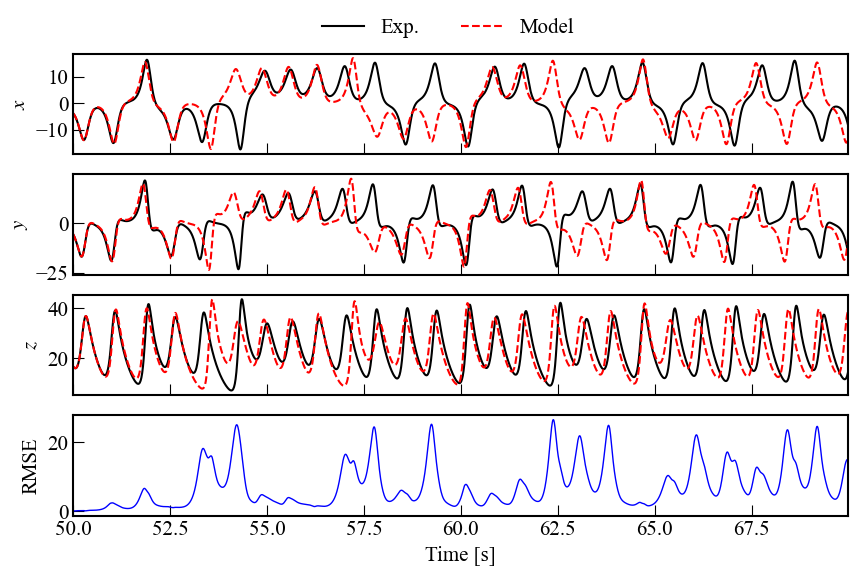

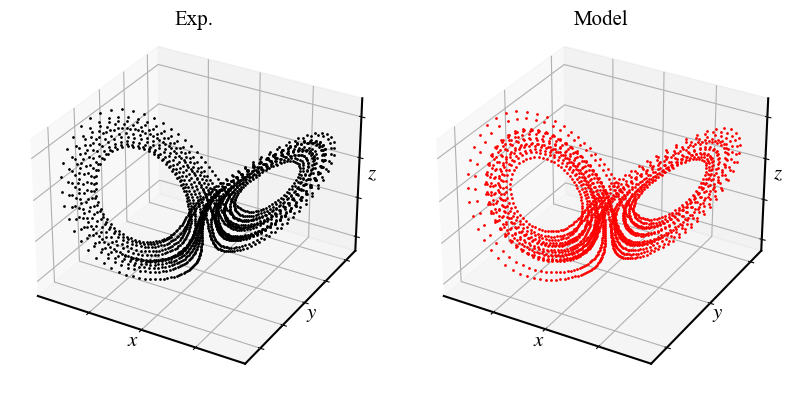

In [111]:
### Setting ELM
RIDGE_PARAM = 1e-7
RUN_SIZE = 5000

### Timeseries modeling
FNN_MODEL = TFNN_ELM(x_train.shape[1], HIDDEN_SIZE, x_train.shape[1],
                     INPUT_W_SCALE, ACTIVE_FUNC, SEED)
FNN_MODEL.fit(x_train[:-1], x_train[1:], RIDGE_PARAM)
x_test_hat = FNN_MODEL.freerun(x_train[-1], RUN_SIZE)

timeseries_modeling(x_test, x_test_hat, T_test, 2000, sort=False)
timeseries_modeling_3d(x_test, x_test_hat, T_test, 2000, sort=False)